ЗАДАНИЯ ДЛЯ ПРОЕКТА

Посчитайте волатильность для вашего временного ряда.
Используйте GARCH-модель для предсказания волатильности.
Используйте линейную регрессию для получения прогноза.
Визуализируйте полученное предсказание вместе с фактическим значением.
Сравните результаты и сделайте выводы.
Почему результат модели GARCH получился именно таким?

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.graphics.tsaplots as sgt

In [2]:
data = pd.read_csv(
    '/Users/egor/Documents/data_science_course/SKILLFACTORY/MATH&ML-13. Временные ряды. Часть II/data/ghana_gdp.csv',
    parse_dates=["year"], 
    index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [3]:
import numpy as np
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
data['GDP (current US$)'] = data['GDP (current US$)'].interpolate(method='linear')

In [4]:
data["GDP_vol"] = data.pct_change(1).mul(100).abs()
data["GDP_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Name: GDP_vol, dtype: float64

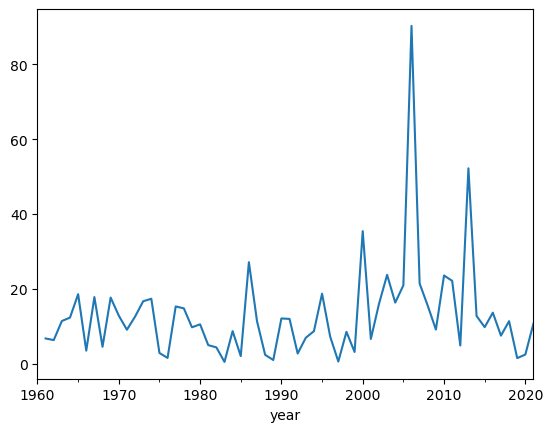

In [5]:
data["GDP_vol"].plot()
plt.show()

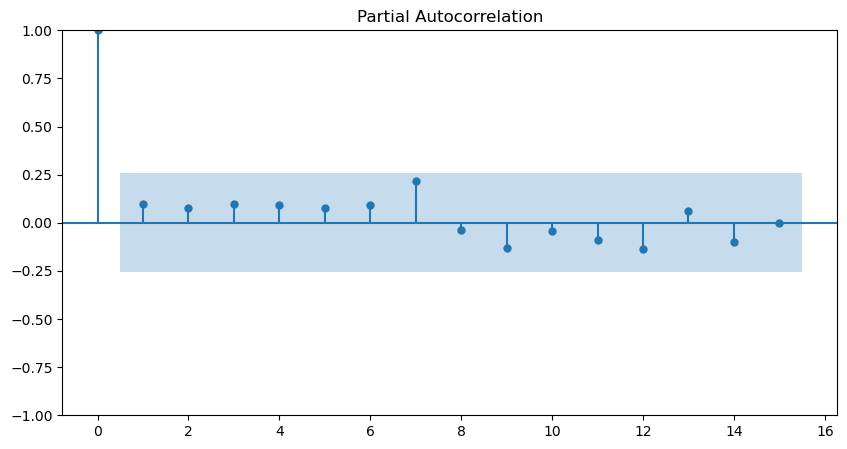

In [6]:
train_df = data.loc[:"2018-01-01"]
test_df = data.loc["2019-01-01":]
plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df["GDP_vol"][1:], lags=15, method="ywm")
plt.show()

In [7]:
adfuller(train_df["GDP_vol"][1:])

(-6.725311059553779,
 3.4014596148856493e-09,
 0,
 57,
 {'1%': -3.5506699942762414,
  '5%': -2.913766394626147,
  '10%': -2.5946240473991997},
 382.739595975669)

In [8]:
garch_df = pd.DataFrame(data["GDP_vol"].loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, "GDP_vol"] = train_df["GDP_vol"].dropna()

In [9]:
garch_df

,GDP_vol
year,
1960-01-01,NaN
1961-01-01,6.789413
1962-01-01,6.357759
1963-01-01,11.448835
1964-01-01,12.363636
...,...
2017-01-01,7.551317
2018-01-01,11.410877
2019-01-01,1.542746


In [11]:
from arch import arch_model

model = arch_model(garch_df["GDP_vol"].dropna(), p=1, q=1)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18833254549992
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4075.976317688216
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.00316972567734
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.59782471363783
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.5978123234891
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


In [12]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                GDP_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Fri, Jul 21 2023   Df Residuals:                       57
Time:                        12:28:16   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3192      2.572      4.790  1.670e-06 [  7.278, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6701     24.741      0.148      0.882 [-44.821, 52.161]
alpha[1]       0.0000  9.202e-02      0.000      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.728e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

In [15]:
predictions_df

,GDP (current US$),GDP_vol,Predictions
year,,,
2019-01-01,6.833754e+10,1.542746,288.548296
2020-01-01,7.004320e+10,2.495937,292.218352
2021-01-01,7.759428e+10,10.780603,295.888409


In [13]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

/Users/egor/anaconda3/lib/python3.10/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


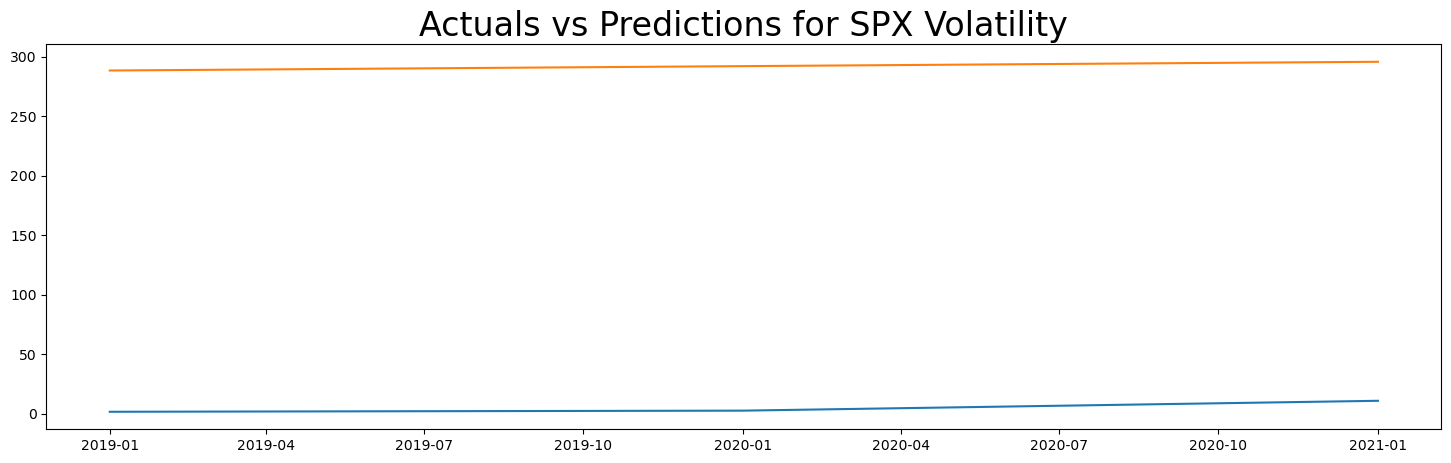

In [14]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size=24)

plt.show()

In [16]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean_squared_error(
    predictions_df["GDP_vol"].abs(), predictions_df["Predictions"]
)

82532.57469459453

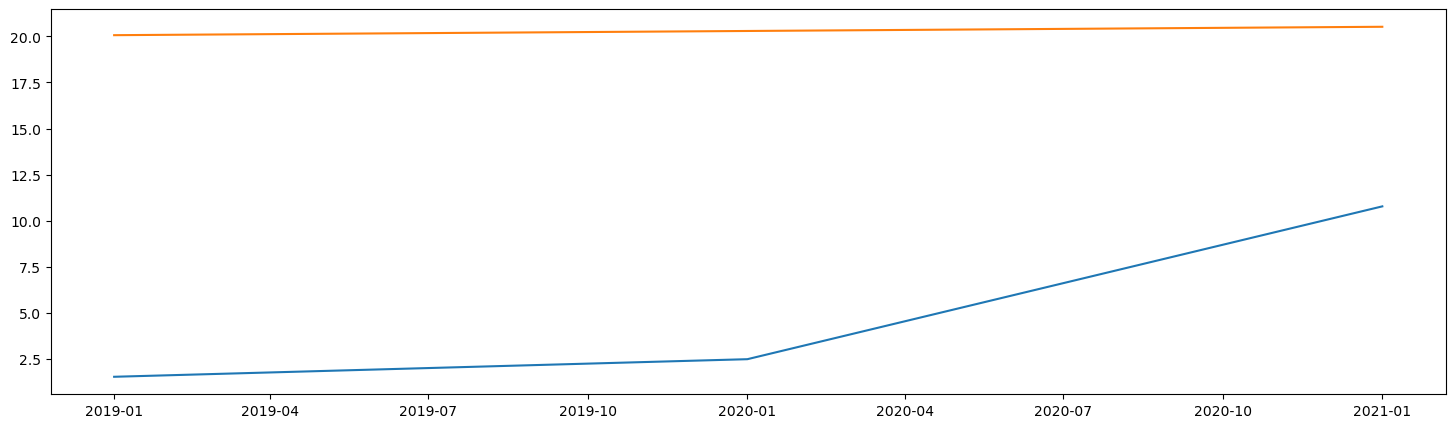

In [17]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["GDP_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["GDP_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP_vol"].fillna(0)
y_test = test_df["GDP_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

In [18]:
!pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 695.7/695.7 kB 12.5 MB/s eta 0:00:00a 0:00:01
  Using cached cmdstanpy-1.1.0-py3-none-any.whl (83 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 26.7 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for prophet: filename=prophet-1.1.4-py3-none-macosx_11_0_arm64.whl size=6716983 sha256=0623e5b9c5a98db42c11610e4412d868fd08644c7ac1c6060ce488d1266d503f
  Stored in directory: /Users/egor/Library/Caches/pip/wheels/21/8e/84/25f752c0bd026343486c376de1563ca9df583f928476aefb47
  Created wh